In [1]:
#Importing Packages
from tqdm import tqdm
import numpy as np
from tinygp import kernels, GaussianProcess
from scipy.stats import multivariate_normal
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import tinygp_model,tinygp_2process_model
from src.examples_functions import truth_posterior_predictive,bias_posterior_predictive
from src.examples_functions import posterior_predictive_realisations
from src.examples_functions import singleprocess_posterior_predictive_realisations

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
def plotting_input(X,Y,Y2,ox,odata,cx,cdata,s=10):
    plt.plot(X,Y,label='Truth',alpha=0.6)
    plt.plot(X,Y2,label='Bias',alpha=0.6)
    plt.plot(X,Y+Y2,label='Bias+Truth',alpha=0.6)
    plt.scatter(ox,odata,label='Observations',alpha=0.8,s=s)
    plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.8,s=s)
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.legend()

def plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,truth_realisations,bias_realisations,s=10):
    plt.plot(X,Y,label='Truth',alpha=1.0,linewidth=2)
    plt.plot(X,Y2,label='Bias',alpha=1.0,linewidth=2)
    plt.plot(X,Y+Y2,label='Bias+Truth',alpha=1.0,linewidth=2)
    plt.scatter(ox,odata,color='b',label='Observational data',alpha=0.7,s=s)
    plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.7,s=s)

    truth_pred_mean = truth_realisations.mean(axis=0)
    truth_pred_std = truth_realisations.std(axis=0)
    plt.plot(nx,truth_pred_mean,label='Truth Mean',color='m',alpha=1.0,linewidth=2)
    plt.fill_between(nx,truth_pred_mean+truth_pred_std,truth_pred_mean-truth_pred_std,label='Truth StdDev',color='m',alpha=0.3)
    bias_pred_mean = bias_realisations.mean(axis=0)
    bias_pred_std = bias_realisations.std(axis=0)
    plt.plot(nx,bias_pred_mean,label='Bias Mean',color='r',alpha=1.0,linewidth=2)
    plt.fill_between(nx,bias_pred_mean+bias_pred_std,bias_pred_mean-bias_pred_std,label='Bias StdDev',color='r',alpha=0.3)

    plt.ylim(-5,5)
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.legend()

def realisations_2process(nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,npr,nppr):
    nx = X[::5] # locations where predictions will be made
    num_parameter_realisations = npr
    num_posterior_pred_realisations = nppr

    truth_realisations = posterior_predictive_realisations(
        truth_posterior_predictive,nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,
        num_parameter_realisations,num_posterior_pred_realisations)
    truth_realisations = truth_realisations.reshape(-1,truth_realisations.shape[-1])

    bias_realisations = posterior_predictive_realisations(
        bias_posterior_predictive,nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,
        num_parameter_realisations,num_posterior_pred_realisations)
    bias_realisations = bias_realisations.reshape(-1,bias_realisations.shape[-1])

    return(truth_realisations,bias_realisations)

In [3]:
X = jnp.arange(0,100,0.1)

sample: 100%|██████████| 3000/3000 [00:43<00:00, 69.41it/s, 3 steps of size 4.24e-01. acc. prob=0.92]  



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      2.73      1.75      2.32      0.37      5.12   1458.56      1.00
  blengthscale      9.30      3.47      8.81      3.71     14.43   1463.15      1.00
         bmean     -0.83      0.81     -0.85     -2.28      0.38   1928.75      1.00
      kern_var      1.66      0.43      1.60      1.02      2.28   1009.75      1.00
   lengthscale      2.98      0.08      2.98      2.87      3.13   1109.24      1.00
          mean      0.55      0.39      0.56     -0.12      1.16   2005.20      1.00

Number of divergences: 2
Time Taken: 43.86853535845876


sample: 100%|██████████| 3000/3000 [00:23<00:00, 126.20it/s, 7 steps of size 5.99e-01. acc. prob=0.91] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      1.99      0.59      1.89      1.16      2.89    957.74      1.00
  lengthscale      3.02      0.09      3.02      2.88      3.16   1028.78      1.00
         mean     -0.52      0.37     -0.52     -1.17      0.05   1207.47      1.00

Number of divergences: 0
Time Taken: 24.135108709335327


sample: 100%|██████████| 3000/3000 [00:05<00:00, 528.15it/s, 7 steps of size 4.58e-01. acc. prob=0.93] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      1.91      1.06      1.63      0.60      3.37    850.36      1.00
  lengthscale      3.49      0.54      3.49      2.60      4.34    991.76      1.00
         mean     -1.04      0.42     -1.03     -1.65     -0.28   1098.67      1.00

Number of divergences: 0
Time Taken: 5.9725545682013035


100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


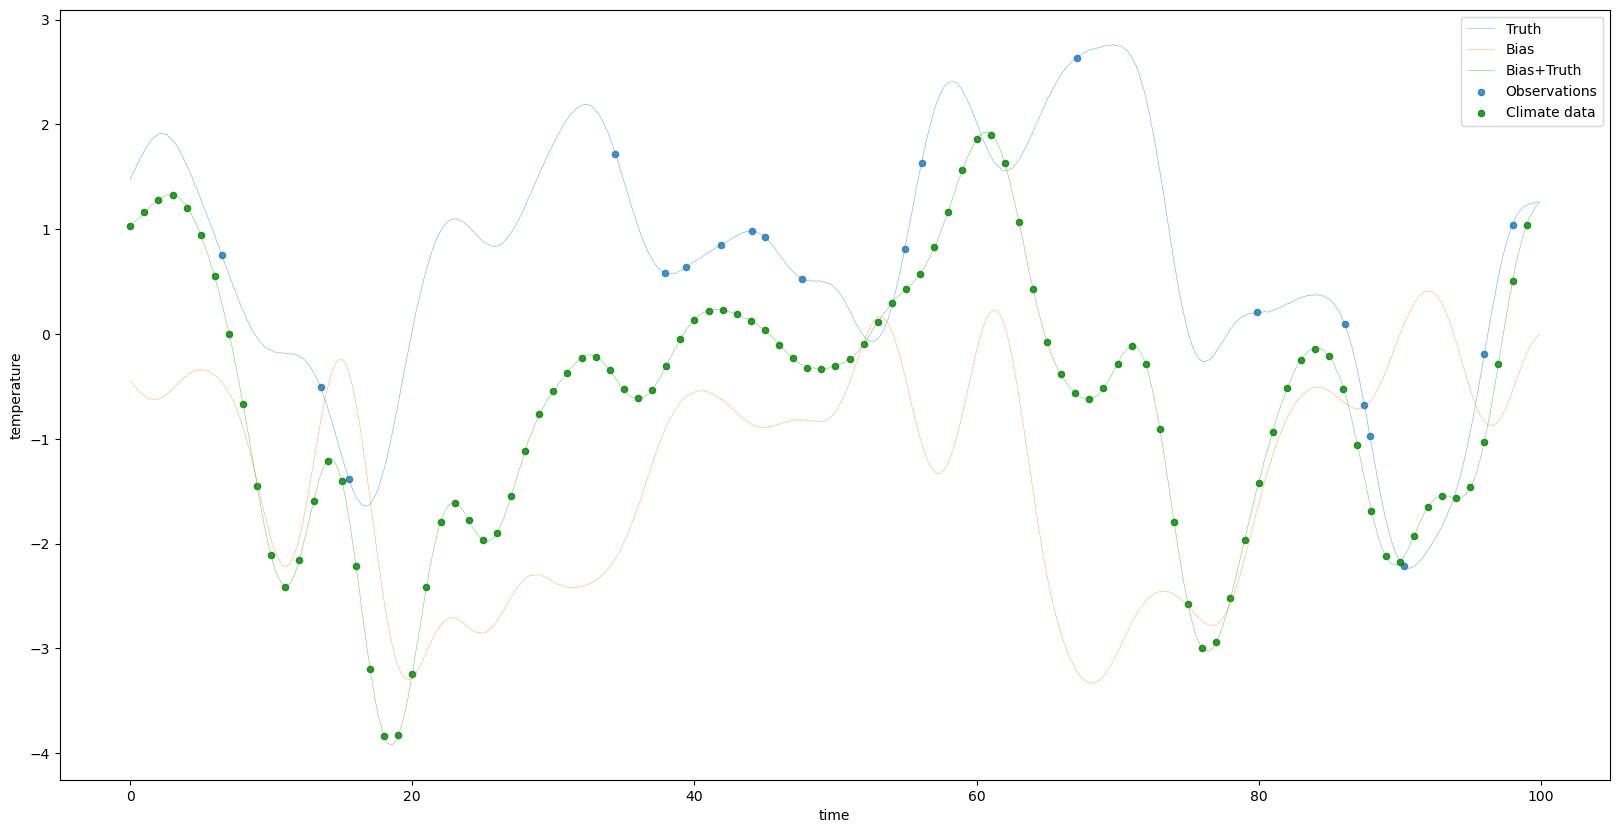

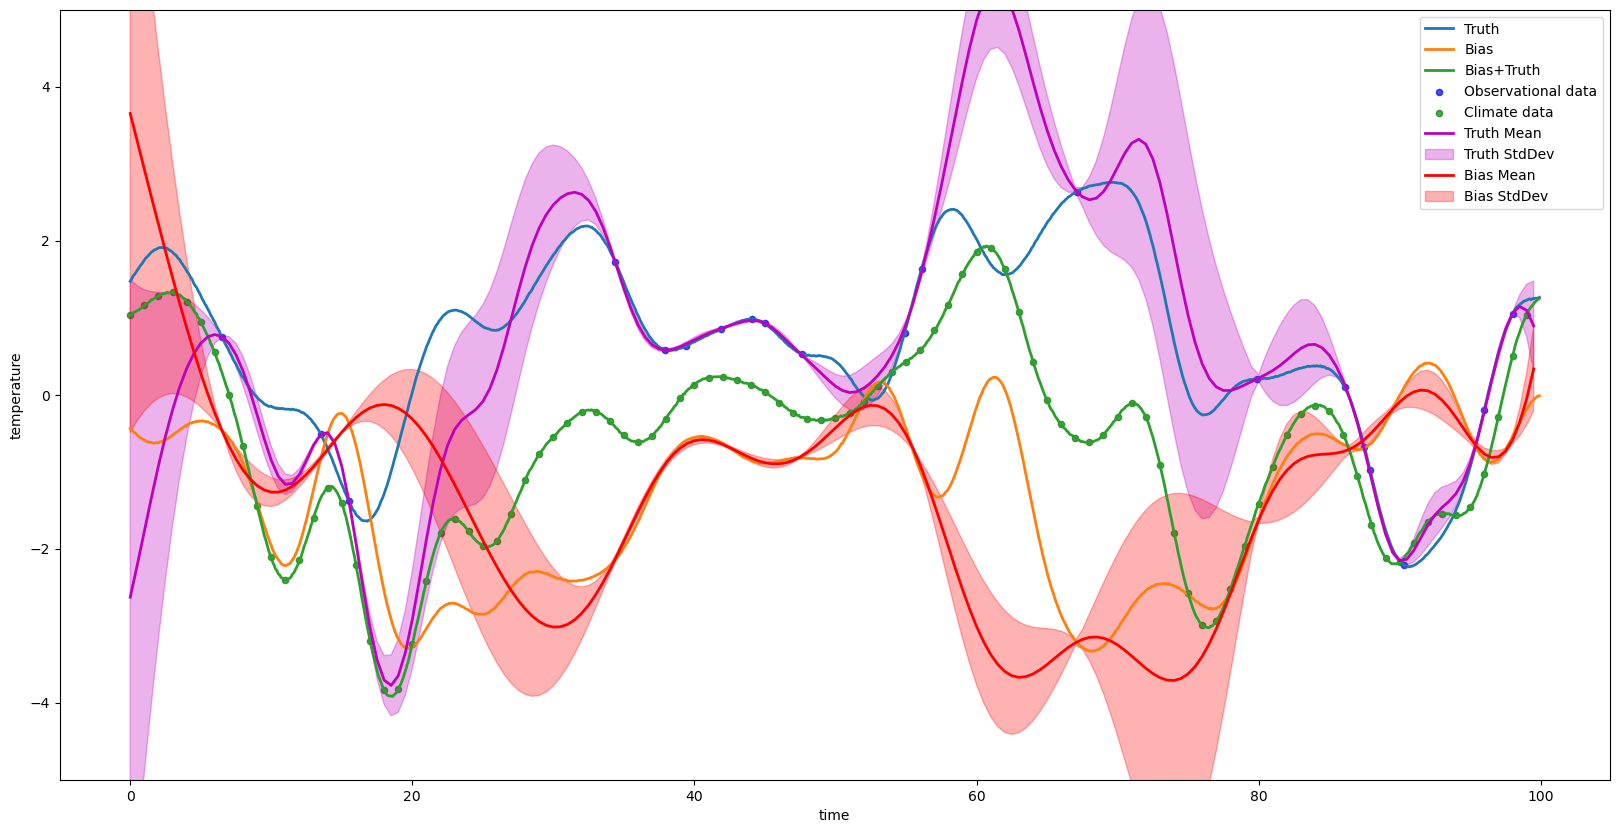

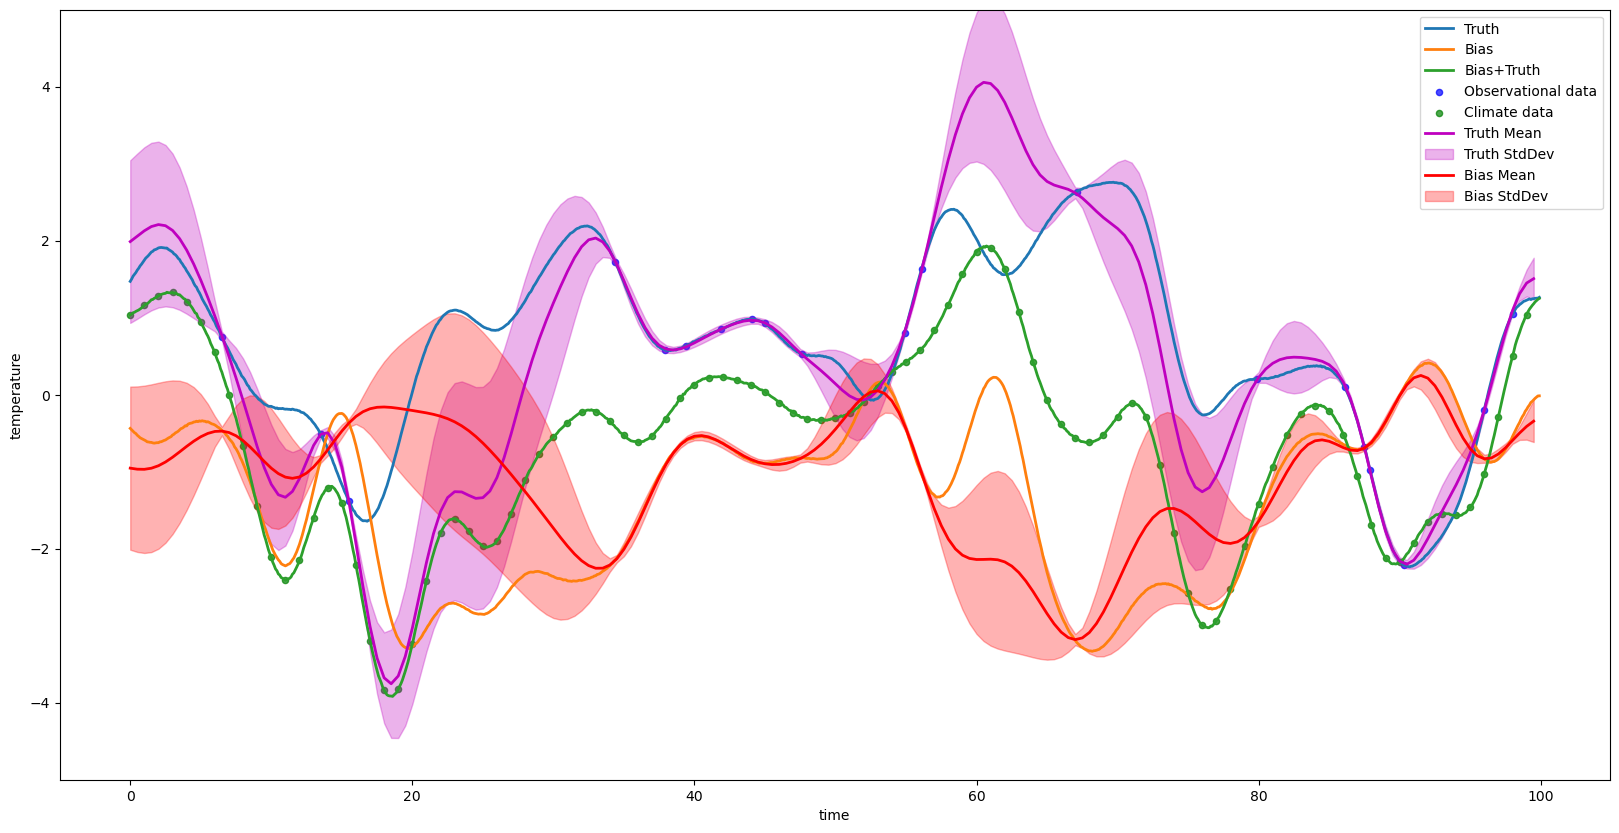

In [8]:
# Scenario: Similar Lengthscales, Sparse Observations
onoise=1e-5
bnoise=1e-5
cnoise=onoise+bnoise
jitter=1e-5

GP = GaussianProcess(1 * kernels.ExpSquared(3),X,diag=onoise,mean=1.0)
Y = GP.sample(rng_key)

GP2 = GaussianProcess(1 * kernels.ExpSquared(3),X,diag=bnoise,mean=-1.0)
rng_key, rng_key_ = random.split(rng_key)
Y2 = GP2.sample(rng_key)

cx = X[::10] 
cdata = (Y+Y2)[::10] 
osample = np.random.choice(range(X.size), size=int(0.2*cx.size), replace=False)
ox = X[osample]
odata = Y[osample]

plt.figure(figsize=(20,10))
plotting_input(X,Y,Y2,ox,odata,cx,cdata,s=20)

mcmc_2process = run_inference(
    tinygp_2process_model, rng_key_, 1000, 2000,
    cx,ox=ox,cdata=cdata,odata=odata,onoise=onoise,cnoise=cnoise)
idata_2process = az.from_numpyro(mcmc_2process)
nx = X[::5] # locations where predictions will be made

truth_realisations,bias_realisations = realisations_2process(
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,20,20)

plt.figure(figsize=(20,10))
plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,truth_realisations,bias_realisations,s=20)

mcmc_climate = run_inference(tinygp_model, rng_key_, 1000, 2000, cx,data=cdata,noise=cnoise)
idata_climate = az.from_numpyro(mcmc_climate)
sp_climate_realisations = singleprocess_posterior_predictive_realisations(ox,cx,idata_climate,cnoise,10,10)

bdata_realisations = sp_climate_realisations - odata
bdata_pred = bdata_realisations.mean(axis=(0,1))
bnoise = bdata_realisations.std(axis=(0,1)).mean()
mcmc_bias = run_inference(tinygp_model, rng_key_, 1000, 2000, ox,data=bdata_pred,noise=bnoise)
idata_bias = az.from_numpyro(mcmc_bias)
sp_bias_realisations = singleprocess_posterior_predictive_realisations(nx,ox,idata_bias,bnoise,20,20)
sp_bias_realisations = sp_bias_realisations.reshape(-1,sp_bias_realisations.shape[-1])
sp_climate_realisations = singleprocess_posterior_predictive_realisations(nx,cx,idata_climate,cnoise,20,20)
sp_climate_realisations = sp_climate_realisations.reshape(-1,sp_climate_realisations.shape[-1])
sp_truth_realisations = sp_climate_realisations - sp_bias_realisations

plt.figure(figsize=(20,10))
plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,sp_truth_realisations,sp_bias_realisations,s=20)

sample: 100%|██████████| 3000/3000 [00:43<00:00, 68.86it/s, 7 steps of size 3.77e-01. acc. prob=0.93]  



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      2.15      1.68      1.68      0.21      4.28   1221.64      1.00
  blengthscale     10.09      4.14      9.59      3.83     17.08   1418.27      1.00
         bmean     -0.61      0.84     -0.65     -1.95      0.79   1013.56      1.00
      kern_var      1.46      0.29      1.42      0.98      1.89   1114.87      1.00
   lengthscale      1.11      0.04      1.11      1.04      1.17   1058.88      1.00
          mean      0.77      0.54      0.79     -0.10      1.65   1124.18      1.00

Number of divergences: 0
Time Taken: 44.20828412473202


sample: 100%|██████████| 3000/3000 [00:21<00:00, 141.06it/s, 7 steps of size 5.65e-01. acc. prob=0.91]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      1.62      0.30      1.59      1.14      2.07   1289.36      1.00
  lengthscale      1.11      0.04      1.11      1.05      1.18   1240.30      1.00
         mean     -0.01      0.20     -0.02     -0.34      0.30   1165.98      1.00

Number of divergences: 0
Time Taken: 21.63677705079317


sample: 100%|██████████| 3000/3000 [00:05<00:00, 541.11it/s, 7 steps of size 6.60e-01. acc. prob=0.91]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      4.77      3.04      4.14      0.50      8.75   1086.80      1.00
  lengthscale      7.09      2.04      6.81      3.79     10.10   1088.13      1.00
         mean     -1.26      1.28     -1.29     -3.16      1.07   1150.17      1.00

Number of divergences: 0
Time Taken: 5.833172097802162


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


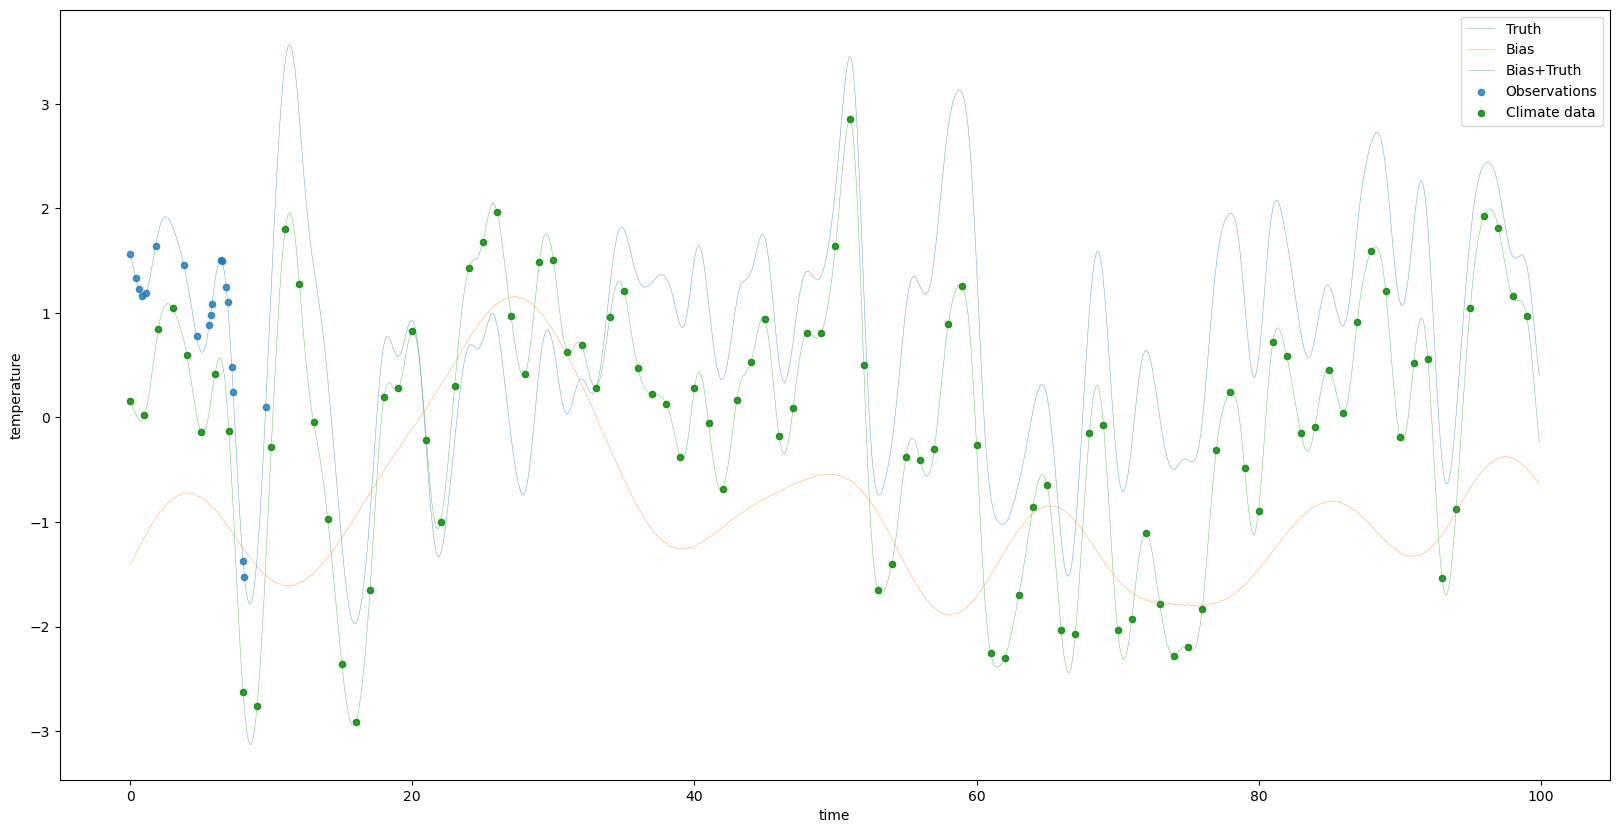

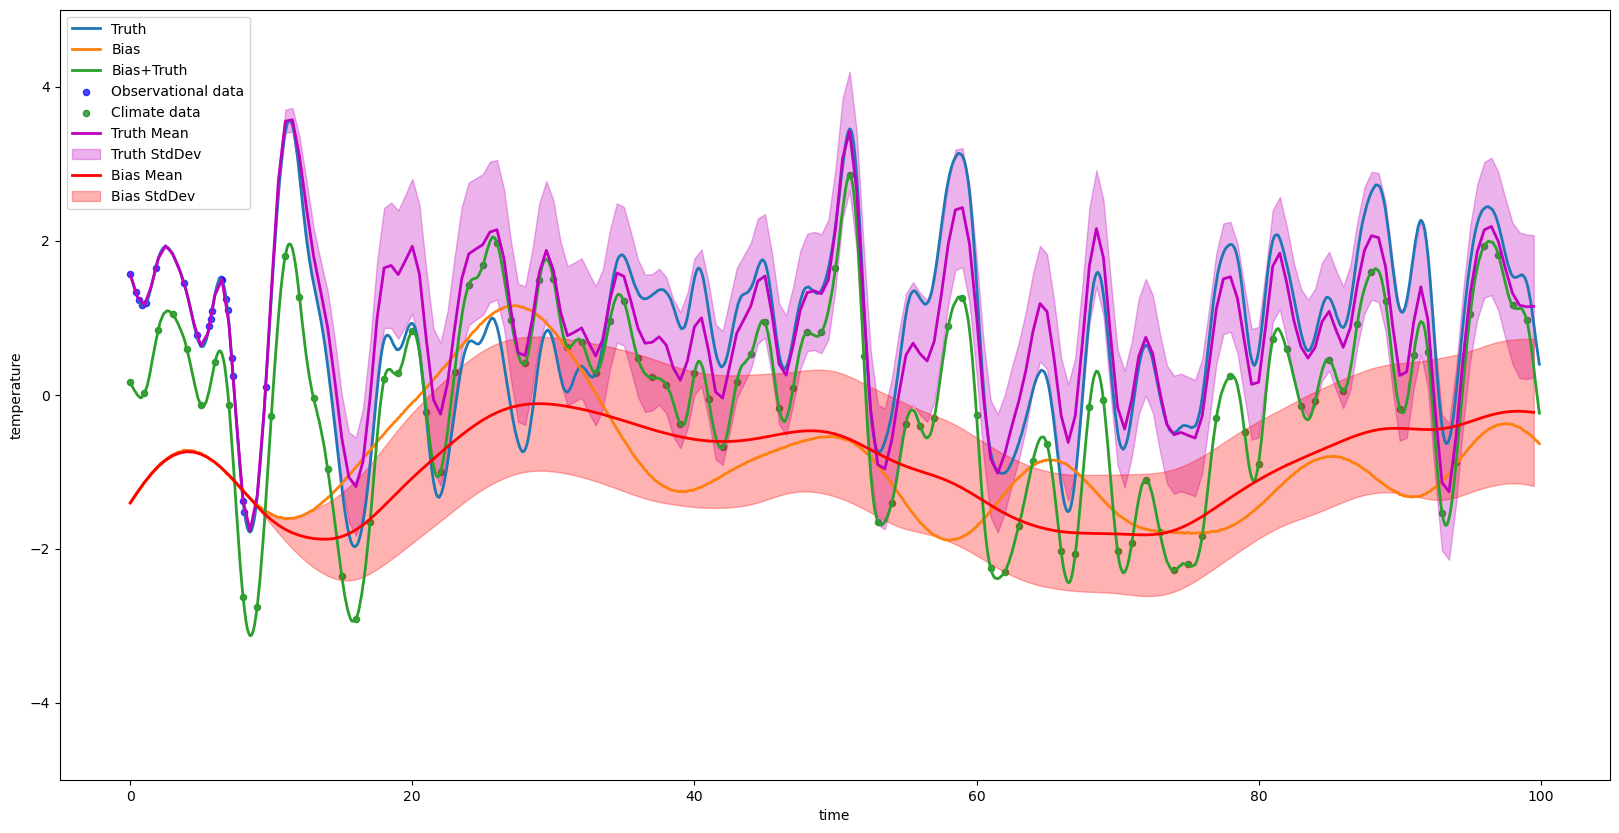

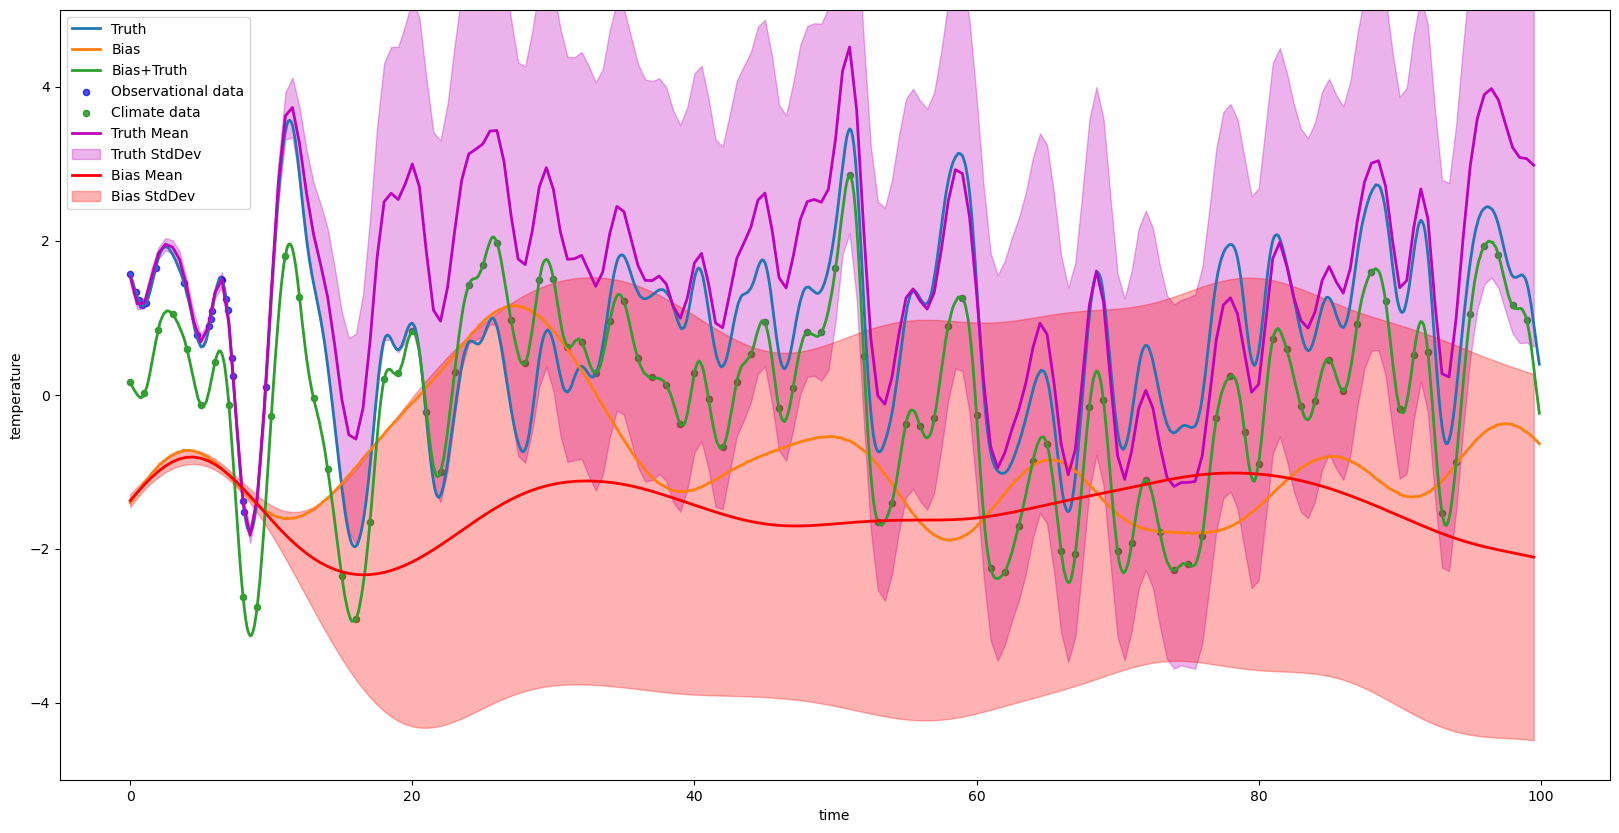

In [9]:
# Scenario: Different Lengthscales, Clustered Observations
onoise=1e-5
bnoise=1e-5
cnoise=onoise+bnoise
jitter=1e-5

GP = GaussianProcess(1 * kernels.ExpSquared(1),X,diag=onoise,mean=1.0)
Y = GP.sample(rng_key)

GP2 = GaussianProcess(1 * kernels.ExpSquared(5),X,diag=bnoise,mean=-1.0)
rng_key, rng_key_ = random.split(rng_key)
Y2 = GP2.sample(rng_key)

cx = X[::10] 
cdata = (Y+Y2)[::10] 
osample = np.random.choice(range(int(X.size *0.1)), size=int(0.2*cx.size), replace=False)
ox = X[osample]
odata = Y[osample]

plt.figure(figsize=(20,10))
plotting_input(X,Y,Y2,ox,odata,cx,cdata,s=20)

mcmc_2process = run_inference(
    tinygp_2process_model, rng_key_, 1000, 2000,
    cx,ox=ox,cdata=cdata,odata=odata,onoise=onoise,cnoise=cnoise)
idata_2process = az.from_numpyro(mcmc_2process)
nx = X[::5] # locations where predictions will be made

truth_realisations,bias_realisations = realisations_2process(
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,20,20)

plt.figure(figsize=(20,10))
plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,truth_realisations,bias_realisations,s=20)

mcmc_climate = run_inference(tinygp_model, rng_key_, 1000, 2000, cx,data=cdata,noise=cnoise)
idata_climate = az.from_numpyro(mcmc_climate)
sp_climate_realisations = singleprocess_posterior_predictive_realisations(ox,cx,idata_climate,cnoise,10,10)

bdata_realisations = sp_climate_realisations - odata
bdata_pred = bdata_realisations.mean(axis=(0,1))
bnoise = bdata_realisations.std(axis=(0,1)).mean()
mcmc_bias = run_inference(tinygp_model, rng_key_, 1000, 2000, ox,data=bdata_pred,noise=bnoise)
idata_bias = az.from_numpyro(mcmc_bias)
sp_bias_realisations = singleprocess_posterior_predictive_realisations(nx,ox,idata_bias,bnoise,20,20)
sp_bias_realisations = sp_bias_realisations.reshape(-1,sp_bias_realisations.shape[-1])
sp_climate_realisations = singleprocess_posterior_predictive_realisations(nx,cx,idata_climate,cnoise,20,20)
sp_climate_realisations = sp_climate_realisations.reshape(-1,sp_climate_realisations.shape[-1])
sp_truth_realisations = sp_climate_realisations - sp_bias_realisations

plt.figure(figsize=(20,10))
plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,sp_truth_realisations,sp_bias_realisations,s=20)

sample: 100%|██████████| 3000/3000 [01:11<00:00, 41.98it/s, 19 steps of size 1.62e-01. acc. prob=0.94]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      2.44      1.51      2.10      0.37      4.45   1268.91      1.00
  blengthscale      6.54      3.73      5.17      2.79     11.96    617.03      1.00
         bmean     -0.56      0.69     -0.57     -1.70      0.54    852.10      1.00
      kern_var      1.60      0.50      1.57      0.77      2.34    627.75      1.00
   lengthscale      2.83      0.08      2.83      2.70      2.97    788.65      1.00
          mean      0.79      0.35      0.79      0.17      1.33   1306.87      1.00

Number of divergences: 0
Time Taken: 72.21102187782526


sample: 100%|██████████| 3000/3000 [00:21<00:00, 142.42it/s, 3 steps of size 6.22e-01. acc. prob=0.91] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      2.33      0.63      2.25      1.41      3.34    934.19      1.00
  lengthscale      2.90      0.07      2.90      2.76      3.01    992.45      1.00
         mean      0.24      0.39      0.25     -0.41      0.85   1174.51      1.00

Number of divergences: 0
Time Taken: 21.428687814623117


sample: 100%|██████████| 3000/3000 [00:05<00:00, 510.37it/s, 15 steps of size 3.51e-01. acc. prob=0.86]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      3.35      1.49      3.02      1.36      5.46    724.29      1.01
  lengthscale      2.47      0.86      2.61      0.97      3.64    420.53      1.00
         mean     -0.33      0.53     -0.34     -1.16      0.54    626.04      1.00

Number of divergences: 0
Time Taken: 6.176302012056112


100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


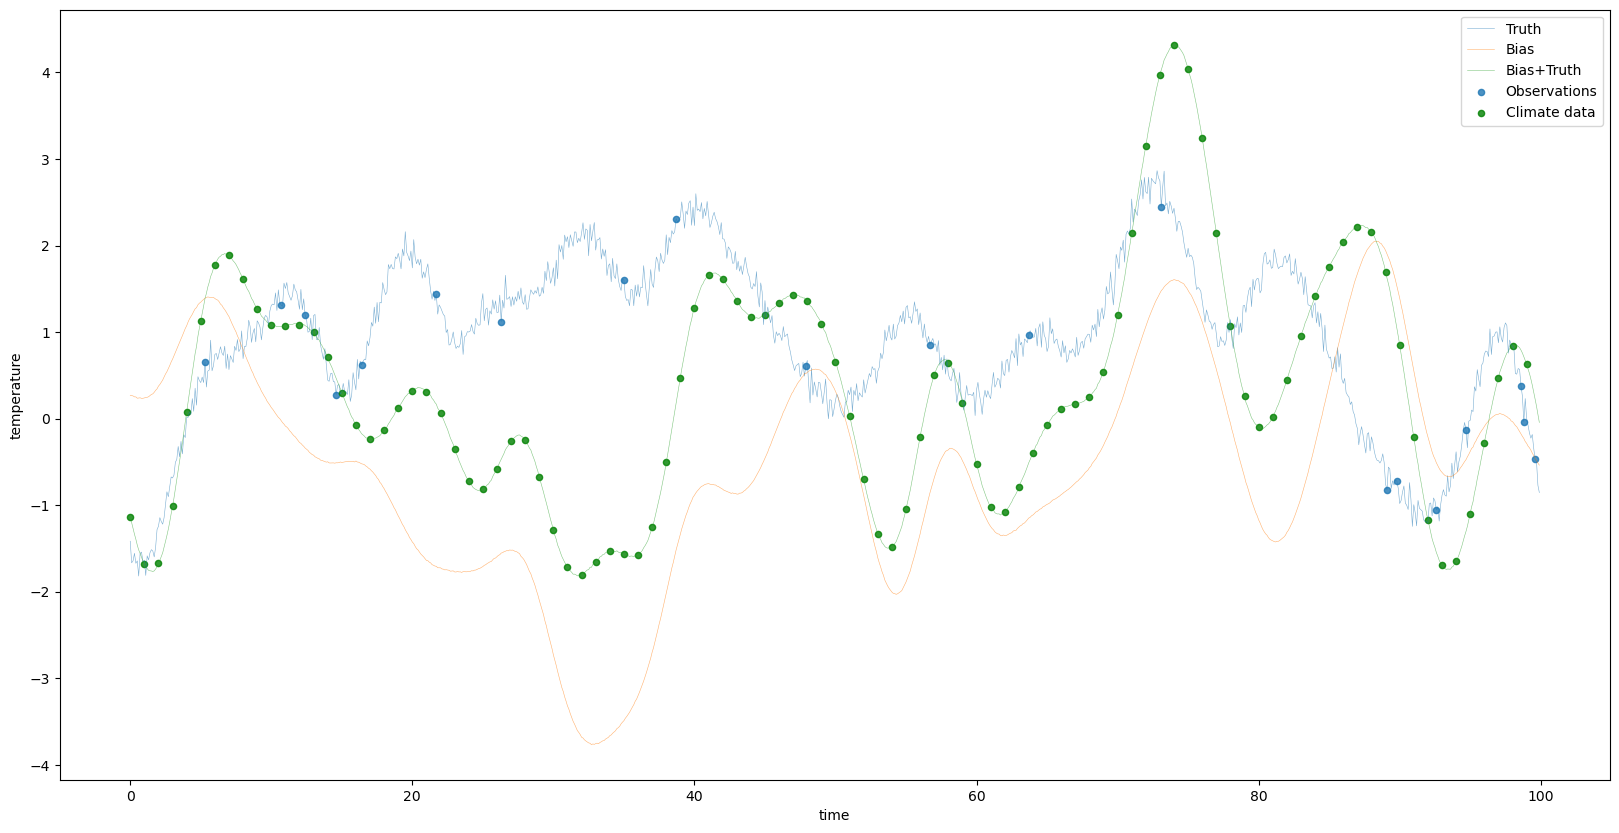

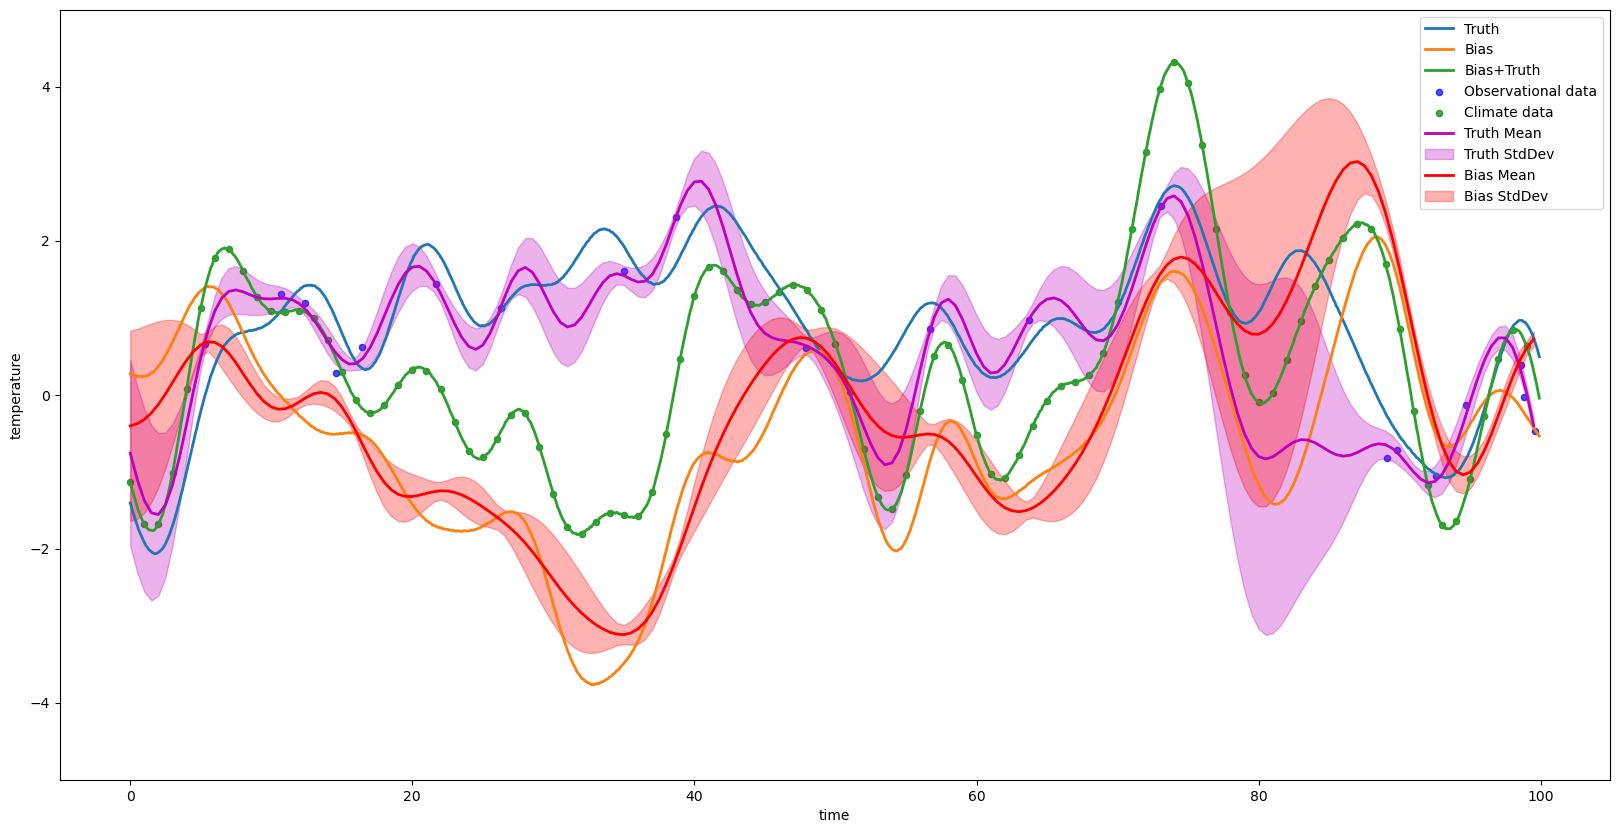

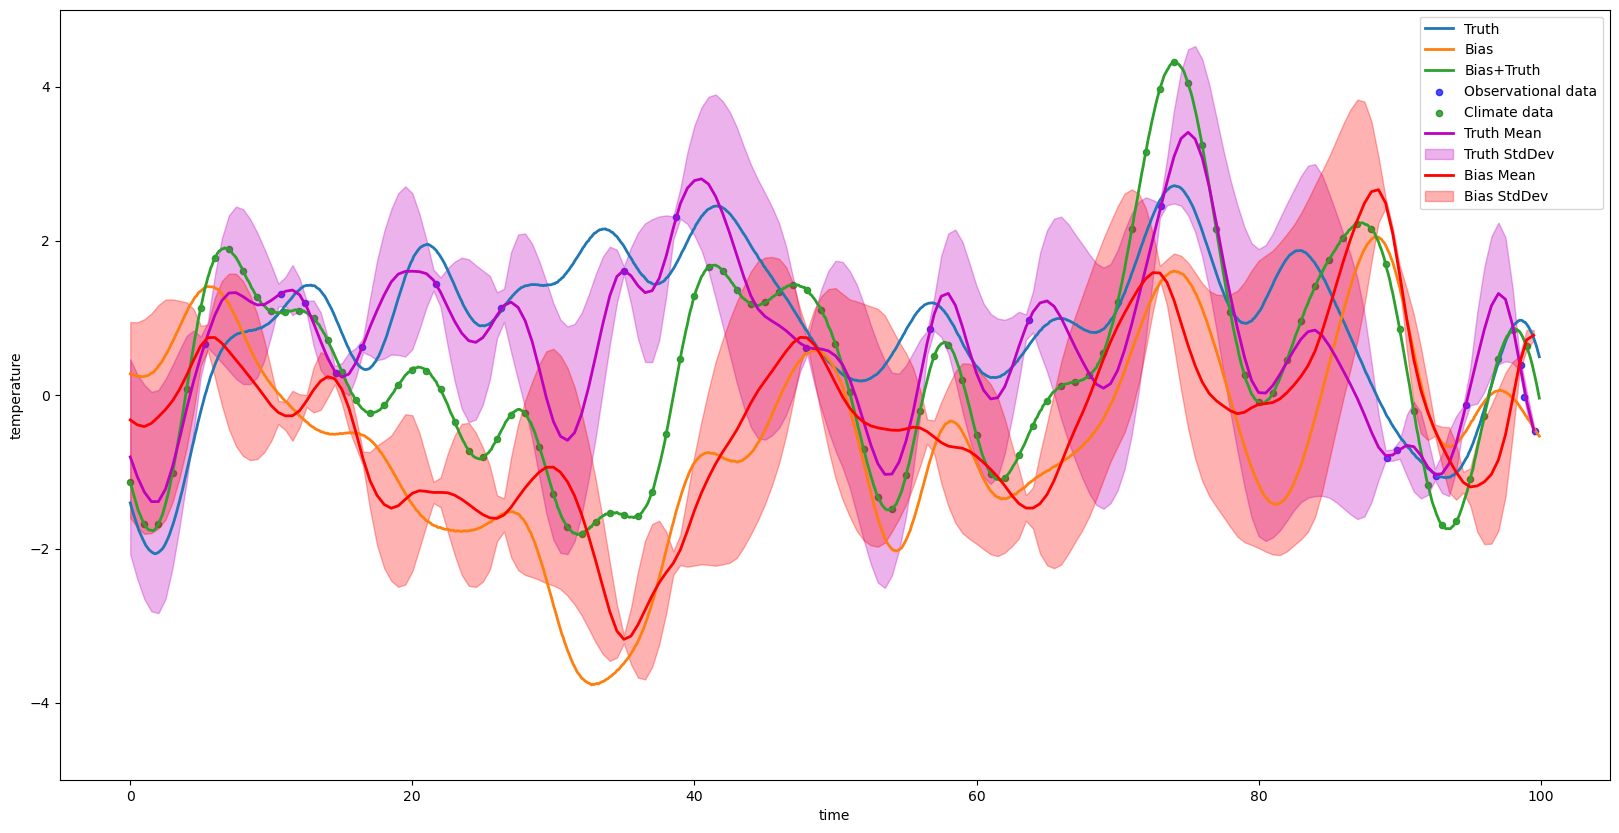

In [13]:
# Scenario: Noisy and Sparse Observations, Similar Lengthscales
onoise=1e-2
bnoise=1e-5
cnoise=1e-5
jitter=1e-5

GP = GaussianProcess(1 * kernels.ExpSquared(3),X,diag=onoise,mean=1.0)
Y_noise = GP.sample(rng_key)
GP = GaussianProcess(1 * kernels.ExpSquared(3),X,diag=jitter,mean=1.0)
Y = GP.sample(rng_key)

GP2 = GaussianProcess(1 * kernels.ExpSquared(3),X,diag=bnoise,mean=-1.0)
rng_key, rng_key_ = random.split(rng_key)
Y2 = GP2.sample(rng_key)

cx = X[::10] 
cdata = (Y+Y2)[::10] 
osample = np.random.choice(range(X.size), size=int(0.2*cx.size), replace=False)
ox = X[osample]
odata = Y_noise[osample]

plt.figure(figsize=(20,10))
plotting_input(X,Y_noise,Y2,Y+Y2,ox,odata,cx,cdata,s=20)

mcmc_2process = run_inference(
    tinygp_2process_model, rng_key_, 1000, 2000,
    cx,ox=ox,cdata=cdata,odata=odata,onoise=onoise,cnoise=cnoise)
idata_2process = az.from_numpyro(mcmc_2process)
nx = X[::5] # locations where predictions will be made

truth_realisations,bias_realisations = realisations_2process(
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,20,20)

plt.figure(figsize=(20,10))
plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,truth_realisations,bias_realisations,s=20)

mcmc_climate = run_inference(tinygp_model, rng_key_, 1000, 2000, cx,data=cdata,noise=cnoise)
idata_climate = az.from_numpyro(mcmc_climate)
sp_climate_realisations = singleprocess_posterior_predictive_realisations(ox,cx,idata_climate,cnoise,10,10)

bdata_realisations = sp_climate_realisations - odata
bdata_pred = bdata_realisations.mean(axis=(0,1))
bnoise = bdata_realisations.std(axis=(0,1)).mean()
mcmc_bias = run_inference(tinygp_model, rng_key_, 1000, 2000, ox,data=bdata_pred,noise=bnoise)
idata_bias = az.from_numpyro(mcmc_bias)
sp_bias_realisations = singleprocess_posterior_predictive_realisations(nx,ox,idata_bias,bnoise,20,20)
sp_bias_realisations = sp_bias_realisations.reshape(-1,sp_bias_realisations.shape[-1])
sp_climate_realisations = singleprocess_posterior_predictive_realisations(nx,cx,idata_climate,cnoise,20,20)
sp_climate_realisations = sp_climate_realisations.reshape(-1,sp_climate_realisations.shape[-1])
sp_truth_realisations = sp_climate_realisations - sp_bias_realisations

plt.figure(figsize=(20,10))
plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,sp_truth_realisations,sp_bias_realisations,s=20)